In [1]:

import os
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary

In [22]:
# Device configuration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = 'cuda'


### Based on https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder 

In [3]:
class Dis(nn.Module):
    def __init__(self):
        super(Dis,self).__init__()
        self.discriminator = nn.Sequential(
                nn.Linear(64*4,64),
                nn.LeakyReLU(0.2),
                nn.Linear(64, 16),
                nn.LeakyReLU(0.2),
                nn.Linear(16,1),
                nn.Sigmoid(),
                ).to(device)
    def forward(self,x):
        x = x.to(device)
        dis = self.discriminator
        
        return dis(x.view(-1,64*4))

class AAutoencoder(nn.Module):
    def __init__(self):
        super(AAutoencoder, self).__init__()
        
        # Input size: [batch, 1, 32, 32]
        # Output size: [batch, 1, 32, 32]
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 4, stride=2, padding=1),            # [batch, 8, 16, 16]
            nn.ReLU(),
            nn.Conv2d(8, 16, 4, stride=2, padding=1),           # [batch, 16, 8, 8]
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, stride=2, padding=1),           # [batch, 32, 4, 4]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),           # [batch, 64, 2, 2]
            nn.ReLU(),
        ).to(device)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [batch, 32, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # [batch, 16, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1),  # [batch, 8, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 4, stride=2, padding=1),   # [batch, 1, 32, 32]
            nn.Sigmoid(),
        ).to(device)
        
        self.discriminator = Dis().to(device)
        
    def forward(self, x):
        x = x.to(device)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return encoded,decoded ,discriminated

## Model summary

Didn't found how to install torchsummary via conda. Using pip worked well for me

In [4]:
a1 = AAutoencoder()
summary(a1,(1,32,32))

/home/austrotaxus/anaconda3/envs/marsanomalies/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 GeForce GTX 660 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]             136
              ReLU-2            [-1, 8, 16, 16]               0
            Conv2d-3             [-1, 16, 8, 8]           2,064
              ReLU-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 4, 4]           8,224
              ReLU-6             [-1, 32, 4, 4]               0
            Conv2d-7             [-1, 64, 2, 2]          32,832
              ReLU-8             [-1, 64, 2, 2]               0
   ConvTranspose2d-9             [-1, 32, 4, 4]          32,800
             ReLU-10             [-1, 32, 4, 4]               0
  ConvTranspose2d-11             [-1, 16, 8, 8]           8,208
             ReLU-12             [-1, 16, 8, 8]               0
  ConvTranspose2d-13            [-1, 8, 16, 16]           2,056
             ReLU-14            [-1, 8,

## Load data

In [5]:
! ls data # Data must be stored in data folder

ESP_011261_1960_BG12_0.IMG  ESP_011261_1960_RED0_0.IMG


In [6]:
from matplotlib.image import imread
from extract_patches import *

img_name = 'ESP_011261_1960_RED0_0.IMG'
images, ids = extract_patches_from_img(img_name, patch_size=32)

/home/austrotaxus/anaconda3/envs/marsanomalies/lib/python3.6/site-packages/PIL/Image.py:2618: DecompressionBombWarning: Image size (102400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(np.squeeze(img))

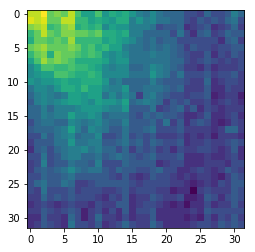

In [8]:
imshow(images[9])

In [9]:
import pytorch_utils as pu
import time
tensor_images = pu.numpy_images_to_tensor_dataset(images)

# converting to range 0..1 so it can be decoded by sigmoid activation
tensor_images = tensor_images / 255

In [10]:
tensor_images.size()

torch.Size([100000, 1, 32, 32])

In [11]:
batch_size = 200

dataset = torch.utils.data.TensorDataset(tensor_images)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)



## Optimizer parameters

Probably should be tuned

In [12]:
model = a1

# Playing with parameteres is for later times

#dec_lr =0.00002
#enc_lr = 0.00002
#dis_lr = 0.001

encoder,decoder,discriminator = a1.encoder,a1.decoder,a1.discriminator
#encode/decode optimizers
optim_Dec = torch.optim.Adam(decoder.parameters())
optim_Enc = torch.optim.Adam(encoder.parameters())
#Discriminator optimizers
optim_Dis = torch.optim.Adam(discriminator.parameters())

criterion = nn.BCELoss()

In [13]:
num_epochs = 1000

In [16]:

def train_model():
    model.train()

    for epoch in range(num_epochs):
        for i, (data,) in enumerate(loader):
            data = data.to(device)
            
            encoder.train()
            decoder.train()
            
            enc = encoder(data)
            recon = decoder(enc)
            dis = discriminator(enc)
            
            # Reconstruction Loss
            
            recon_loss = criterion(recon,data)
            
            optim_Enc.zero_grad()
            optim_Dec.zero_grad()
            
            recon_loss.backward()
            
            optim_Enc.step()
            optim_Dec.step()
            
            # Adversarial Discriminator
            # Probably distribustion could be varied
                    
            encoder.eval()
            z_real_gauss = Variable(torch.randn(data.size()[0], 64*4)).to(device)
            D_real_gauss = discriminator(z_real_gauss)
            
            z_fake_gauss = encoder(data)
            D_fake_gauss = discriminator(z_fake_gauss)
            
            Dis_loss = -torch.mean(torch.log(D_real_gauss) + torch.log(1 - D_fake_gauss ))

            Dis_loss.backward()
            optim_Dis.step()
                       
            # Encoder fool decoder
            encoder.train()
            z_fake_gauss = encoder(data)
            D_fake_gauss = discriminator(z_fake_gauss)
    
            Enc_loss = -torch.mean(torch.log(D_fake_gauss ))

            Enc_loss.backward()
            optim_Enc.step()
                        
            if i % 100 == 0:
                print(time.strftime('%X') + f': {i} batches processed. loss:{recon_loss.item():.6f}')
                print('recon_loss:{:.4f} Enc_loss:{:.4f} Dis_loss:{:.4f}'.format(recon_loss.item(), 
                                                                       Enc_loss.item(),
                                                                       Dis_loss.item()))
        # log
        #if epoch % 10 == 0:
        print('epoch [{}/{}]'.format(epoch+1, num_epochs))
        
    torch.save(model.state_dict(), './conv_autoencoder.pth')

train_model()

15:26:08: 0 batches processed. loss:0.696395
recon_loss:0.6964 Enc_loss:0.7313 Dis_loss:1.3939
15:26:11: 100 batches processed. loss:0.685762
recon_loss:0.6858 Enc_loss:0.6727 Dis_loss:0.7178
15:26:14: 200 batches processed. loss:0.689892
recon_loss:0.6899 Enc_loss:0.7282 Dis_loss:0.6608
15:26:18: 300 batches processed. loss:0.688611
recon_loss:0.6886 Enc_loss:0.6918 Dis_loss:0.6983
15:26:21: 400 batches processed. loss:0.689349
recon_loss:0.6893 Enc_loss:0.7554 Dis_loss:0.6395
epoch [1/1000]
15:26:24: 0 batches processed. loss:0.686433
recon_loss:0.6864 Enc_loss:0.6952 Dis_loss:0.6840
15:26:27: 100 batches processed. loss:0.685338
recon_loss:0.6853 Enc_loss:0.7041 Dis_loss:0.6770


KeyboardInterrupt: 

In [17]:
model.eval()
test_data = tensor_images[1:2]
test_data = test_data.to(device)

In [18]:
test_output = model(test_data)[1]
test_output
test_output.data.cpu().numpy().shape

(1, 1, 32, 32)

This decoder guys seems to be really bad. Not sure wat is the true reason. Probably need more computational powers, different LR or overall implementation has a bug

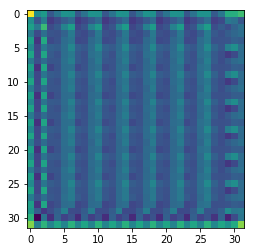

In [19]:
imshow(test_output.data.cpu().numpy()[0])

array([[[0.46841562, 0.45117417, 0.4532387 , ..., 0.4558059 ,
         0.4558824 , 0.45797876],
        [0.45163915, 0.44362736, 0.44910714, ..., 0.44837376,
         0.44756934, 0.44412124],
        [0.4538737 , 0.44846693, 0.4577331 , ..., 0.44297263,
         0.44563025, 0.4474371 ],
        ...,
        [0.4527157 , 0.44484138, 0.4406816 , ..., 0.45114747,
         0.448059  , 0.44854578],
        [0.45660916, 0.434992  , 0.44790125, ..., 0.43837622,
         0.44277865, 0.4479755 ],
        [0.4621845 , 0.4495784 , 0.45668483, ..., 0.45195964,
         0.4554534 , 0.46235925]]], dtype=float32)